In [1]:
import pyro
import torch
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import ExitStack
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive

from causal_pyro.dynamical.handlers import (
    PointObservation,
    SimulatorEventLoop,
    simulate,
    ODEDynamics
)
from causal_pyro.dynamical.ops import State, Trajectory

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

In [2]:
class SimpleSIRDynamics(ODEDynamics):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]):
        dX.S = -self.beta * X.S * X.I
        dX.I = self.beta * X.S * X.I - self.gamma * X.I  # noqa
        dX.R = self.gamma * X.I

    def observation(self, X: State[torch.Tensor]):
        S = pyro.deterministic("S", X.S)
        I = pyro.deterministic("I", X.I)
        R = pyro.deterministic("R", X.R)
        test_kit_sales = torch.relu(pyro.sample("test_kit_sales", dist.Normal(torch.log(X.S + 1), 1)))
        I_obs = pyro.sample("I_obs", dist.Poisson(X.I)) # noisy number of infected actually observed
        R_obs = pyro.sample("R_obs", dist.Poisson(X.R)) # noisy number of recovered actually observed
        return {"test_kit_sales": test_kit_sales, "I_obs": I_obs, "R_obs": R_obs, "S": S, "I": I, "R": R}

# Generate synthetic data from an SIR model

In [3]:
# Assume there is initially a population of 99 million people that are susceptible, 1 million infected, and 0 recovered
init_state = State(S=torch.tensor(99.), I=torch.tensor(1.), R=torch.tensor(0.))
time_period = torch.linspace(0, 3, steps=21)

# We now simulate from the SIR model
beta_true = torch.tensor(0.05)
gamma_true =  torch.tensor(0.5)
sir = SimpleSIRDynamics(beta_true, gamma_true)
sir_traj = simulate(sir, init_state, time_period)

### Plot the simulated trajectories from SIR model

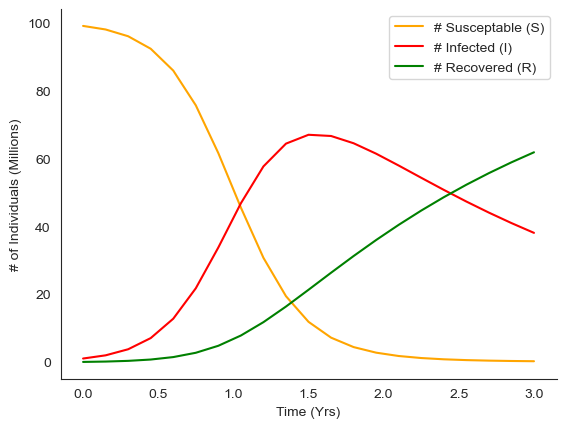

In [4]:
sns.lineplot(x=time_period, y=sir_traj.S, label="# Susceptable (S)", color='orange')
sns.lineplot(x=time_period, y=sir_traj.I, label="# Infected (I)", color='red')
sns.lineplot(x=time_period, y=sir_traj.R, label="# Recovered (R)", color='green')
sns.despine()
plt.xlabel("Time (Yrs)")
plt.ylabel("# of Individuals (Millions)")
plt.legend()

### Sample observed data from the model
 

In [5]:
obs_time_period = torch.arange(0, 1.01, 1/52) # collect data every week for the past 1yr
N_obs = obs_time_period.shape[0]
sir_obs_traj = simulate(sir, init_state, obs_time_period)
data = dict()
for time_ix in range(N_obs):
    data[time_ix] = [obs_time_period[time_ix], sir.observation(sir_obs_traj[time_ix])]

In [6]:
test_kit_sales = torch.stack([data[time_ix][1]["test_kit_sales"] for time_ix in range(N_obs)])
I_obs = torch.stack([data[time_ix][1]["I_obs"] for time_ix in range(N_obs)])
R_obs = torch.stack([data[time_ix][1]["R_obs"] for time_ix in range(N_obs)])

Text(0, 0.5, 'Observed # Recovered (Millions)')

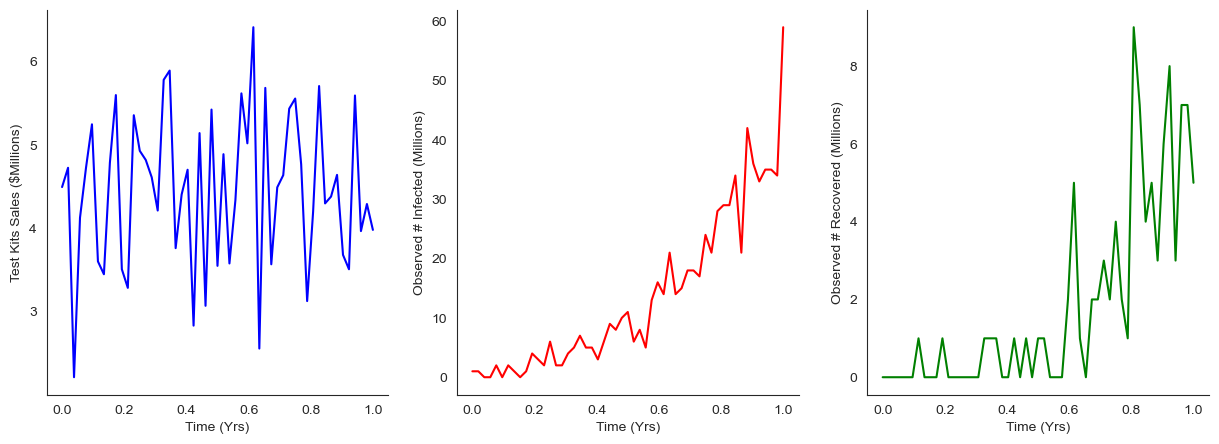

In [7]:
# Plot observed data
fix, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot test kit sales
sns.lineplot(x=obs_time_period, y=test_kit_sales, color='blue', ax=ax[0])
sns.despine()
ax[0].set_xlabel("Time (Yrs)")
ax[0].set_ylabel("Test Kits Sales ($Millions)")

# Plot observed infected
sns.lineplot(x=obs_time_period, y=I_obs, color='red', ax=ax[1])
sns.despine()
ax[1].set_xlabel("Time (Yrs)")
ax[1].set_ylabel("Observed # Infected (Millions)")

# Plot observed recovered
sns.lineplot(x=obs_time_period, y=R_obs, color='green', ax=ax[2])
sns.despine()
ax[2].set_xlabel("Time (Yrs)")
ax[2].set_ylabel("Observed # Recovered (Millions)")

# Perform Inference!

In [12]:
# We place uniform priors on the beta and gamma parameters defining the SIR model 
def model():
    beta = pyro.sample("beta", dist.Uniform(0, 1))
    gamma = pyro.sample("gamma", dist.Uniform(0, 1))
    sir = SimpleSIRDynamics(beta, gamma)
    return sir


def unconditional_sir_model(data, init_state, tspan):
    sir = model()
    return simulate(sir, init_state, tspan)


def conditioned_sir(data, init_state, tspan):
    sir = model()
    observation_managers = []
    for obs in data.values():
        obs_time = obs[0].item()
        obs_data = obs[1]
        observation_managers.append(PointObservation(obs_time, obs_data))
    with SimulatorEventLoop():
        with ExitStack() as stack:
            for manager in observation_managers:
                stack.enter_context(manager)
            traj = simulate(sir, init_state, tspan)
    return traj

In [9]:
guide = AutoMultivariateNormal(conditioned_sir)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(conditioned_sir, guide, adam, loss=Trace_ELBO())
n_steps = 200

# Do gradient steps
pyro.clear_param_store()
for step in range(n_steps):
    loss = svi.step(data, init_state, torch.tensor([0., 3.])) # need tspan to contain all observation times
    print("[iteration %04d] loss: %.4f" % (step + 1, loss / N_obs))
    guide_median = guide.median()
    print("beta post. median est: %.4f, gamma post. median est: %.4f" % (guide_median['beta'].item(), guide_median['gamma'].item()))
        

[iteration 0001] loss: 66.6493
beta post. median est: 0.4665, gamma post. median est: 0.4076
[iteration 0002] loss: 66.4320
beta post. median est: 0.4590, gamma post. median est: 0.4004
[iteration 0003] loss: 65.9829
beta post. median est: 0.4516, gamma post. median est: 0.3933
[iteration 0004] loss: 65.9836
beta post. median est: 0.4441, gamma post. median est: 0.3862
[iteration 0005] loss: 65.4919
beta post. median est: 0.4367, gamma post. median est: 0.3792
[iteration 0006] loss: 65.8017
beta post. median est: 0.4293, gamma post. median est: 0.3723
[iteration 0007] loss: 65.6872
beta post. median est: 0.4219, gamma post. median est: 0.3654
[iteration 0008] loss: 65.6913
beta post. median est: 0.4145, gamma post. median est: 0.3587
[iteration 0009] loss: 64.8473
beta post. median est: 0.4072, gamma post. median est: 0.3519
[iteration 0010] loss: 62.6847
beta post. median est: 0.3998, gamma post. median est: 0.3454
[iteration 0011] loss: 64.3448
beta post. median est: 0.3924, gamma po

# Evaluate the performance of our inference

In [20]:
# Generate samples from the posterior predictive distribution
predictive = Predictive(unconditional_sir_model, guide=guide, num_samples=100)
samples = predictive(data, init_state, torch.tensor([0., .01])) # just trying to get beta and gamma samples

### First, we compare the approximate posterior distribution with the true beta and gamma parameters generating the data

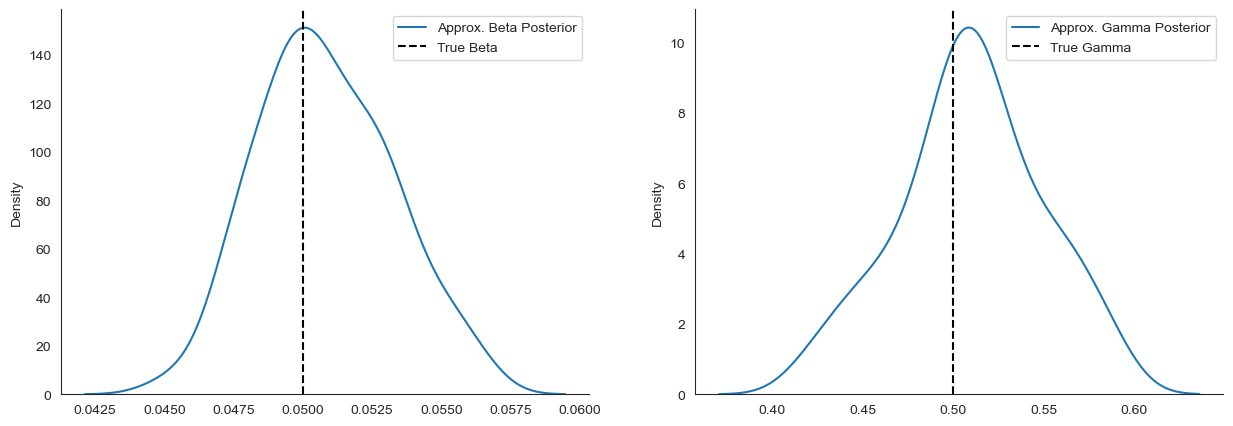

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(samples['beta'], label='Approx. Beta Posterior', ax=ax[0])
ax[0].axvline(beta_true, color='black', label='True Beta', linestyle='--')
sns.despine()
ax[0].legend(loc='upper right')

sns.kdeplot(samples['gamma'], label='Approx. Gamma Posterior', ax=ax[1])
plt.axvline(gamma_true, color='black', label='True Gamma', linestyle='--')
sns.despine()
ax[1].legend(loc='upper right')

### Next, we compare the predictive performance on the held at period between $t=1$ and $t=3$ years

In [33]:
# TODO: we should add functionality so that pyro Predictive gives use predictions of sites in `observation` method...

S_pred = []
I_pred = []
R_pred = []

for beta, gamma in zip(samples['beta'], samples['gamma']):
    sir = SimpleSIRDynamics(beta, gamma)
    sir_traj = simulate(sir, init_state, time_period)
    S_pred.append(sir_traj.S)
    I_pred.append(sir_traj.I)
    R_pred.append(sir_traj.R)

# Reshape as a tensor of postior samples x time matrix
S_pred = torch.stack(S_pred)
I_pred = torch.stack(I_pred)
R_pred = torch.stack(R_pred)

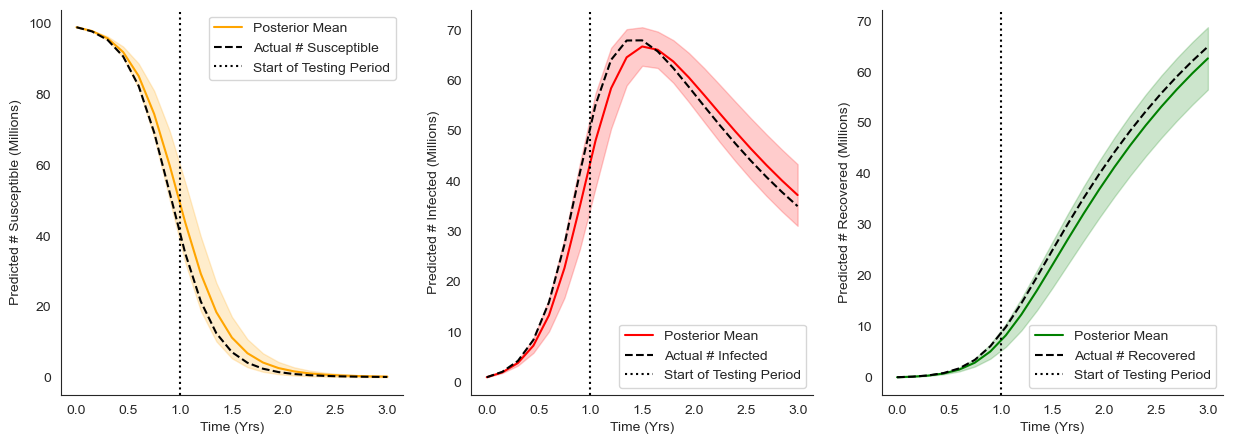

In [48]:
# Plot predicted values for S, I, and R with uncertainty bands (+/- 2 std. devs.)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot predicted susceptible
sns.lineplot(x=time_period, y=S_pred.mean(dim=0), color='orange', ax=ax[0], label='Posterior Mean')
ax[0].fill_between(time_period, S_pred.mean(dim=0) - 2*S_pred.std(dim=0), S_pred.mean(dim=0) + 2*S_pred.std(dim=0), alpha=0.2, color='orange')
sns.despine()
ax[0].set_xlabel("Time (Yrs)")
ax[0].set_ylabel("Predicted # Susceptible (Millions)")

# Plot predicted infected
sns.lineplot(x=time_period, y=I_pred.mean(dim=0), color='red', ax=ax[1], label='Posterior Mean')
ax[1].fill_between(time_period, I_pred.mean(dim=0) - 2*I_pred.std(dim=0), I_pred.mean(dim=0) + 2*I_pred.std(dim=0), alpha=0.2, color='red')
sns.despine()
ax[1].set_xlabel("Time (Yrs)")
ax[1].set_ylabel("Predicted # Infected (Millions)")

# Plot predicted recovered
sns.lineplot(x=time_period, y=R_pred.mean(dim=0), color='green', ax=ax[2], label='Posterior Mean')
ax[2].fill_between(time_period, R_pred.mean(dim=0) - 2*R_pred.std(dim=0), R_pred.mean(dim=0) + 2*R_pred.std(dim=0), alpha=0.2, color='green')
sns.despine()
ax[2].set_xlabel("Time (Yrs)")
ax[2].set_ylabel("Predicted # Recovered (Millions)")

# Plot observed values for S, I, and R with uncertainty bands

# Plot observed susceptible
sns.lineplot(x=time_period, y=sir_traj.S, color='black', ax=ax[0], linestyle='--', label='Actual # Susceptible')
sns.despine()

# Plot observed infected
sns.lineplot(x=time_period, y=sir_traj.I, color='black', ax=ax[1], linestyle='--', label='Actual # Infected')
sns.despine()

# Plot observed recovered
sns.lineplot(x=time_period, y=sir_traj.R, color='black', ax=ax[2], linestyle='--', label='Actual # Recovered')
sns.despine()

# Plot testing period
ax[0].axvline(1, color='black', linestyle='dotted', label='Start of Testing Period')
ax[1].axvline(1, color='black', linestyle='dotted', label='Start of Testing Period')
ax[2].axvline(1, color='black', linestyle='dotted', label='Start of Testing Period')

ax[0].legend()
ax[1].legend()
ax[2].legend()


In [38]:
# Multilevel SIR modeling
# Generate different states for a number of different countries
# Each country conditional on covariates has same dynamics

# Some countries enact different policies at different times
# pool all information together to estimate dynamics

# References
1. https://www.generable.com/post/fitting-a-basic-sir-model-in-stan